<a href="https://colab.research.google.com/github/ravellys/DimReserv/blob/main/Dim_Cisterna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Classes

### Ler dados da APAC

In [3]:
class DadosPrec:
  '''
  objeto para obtenção de dados pluviometricos e extração de metricas
  '''

  def __init__(self, name):
    self.name = name

  def read_file(self):
    self.df = pd.read_csv(name)

  def df_replace_nan(self):
    self.df = self.df.fillna(self.df.mean())  

  def mean(self):
    self.read_file()
    self.df_replace_nan()
    df_ = self.df.drop(['Ano', 'Codigo', 'Posto'], axis=1)
    return df_.mean()

  def quantile(self, q=.05):
    self.read_file()
    self.df_replace_nan()
    df_ = self.df.drop(['Ano', 'Codigo', 'Posto'], axis=1)
    return df_.quantile(q=q, axis=0, numeric_only=True, interpolation='linear')     

### Método de Rippl

In [4]:
class Rippl:
  """
  objeto para dimensionamento de reservatórios pelo metodo de Rippl
  link de exemplo: https://maisengenharia.altoqi.com.br/hidrossanitario/dimensionamento-de-reservatorio-de-agua-da-chuva-pelo-metodo-de-rippl/
  """
  def __init__(self, rainfall, demand, area, cr):
    self.rainfall = rainfall
    self.demand=demand
    self.area=area
    self.cr=cr

  def vol_rainfall (self):
    return self.cr*self.rainfall*self.area/1000

  def vol_reserv(self):
    dif = np.array([max(self.demand-i, 0) for i in self.vol_rainfall()])
    cumullated = np.cumsum(dif) 
    vol = max(cumullated)
    self.vol = vol
    return vol


## TESTES

### Teste de Rippl 

In [5]:
#dados de teste
chuva = np.array([243, 219, 201, 81, 83, 43, 36, 27, 90, 109, 103, 215])
demanda_mensal = 9
area_de_captacao = 152
cr = .8
volume_mensal = cr*chuva*area_de_captacao/1000
vol_reservatorio = 14.110399999999998

In [6]:
def test_rainfall():
  rippl = Rippl(rainfall=chuva, demand=demanda_mensal, area=area_de_captacao, cr=cr) 
  print((rippl.rainfall == chuva).all())


def test_demanda_mensal():
  rippl = Rippl(rainfall=chuva, demand=demanda_mensal, area=area_de_captacao, cr=cr) 
  print(rippl.demand == demanda_mensal) 


def test_cr():
  rippl = Rippl(rainfall=chuva, demand=demanda_mensal, area=area_de_captacao, cr=cr) 
  print(rippl.cr == cr) 


def test_vol_rainfall():
  rippl = Rippl(rainfall=chuva, demand=demanda_mensal, area=area_de_captacao, cr=cr) 
  print((rippl.vol_rainfall() == volume_mensal).all())


def test_vol_reservatorio():
  rippl = Rippl(rainfall=chuva, demand=demanda_mensal, area=area_de_captacao, cr=cr) 
  print(rippl.vol_reserv() == vol_reservatorio)

In [7]:
test_rainfall()
test_demanda_mensal()
test_cr()
test_vol_rainfall()
test_vol_reservatorio()

True
True
True
True
True


# Exemplo

In [113]:
if __name__ == '__main__':
  # Serra Talhada
  name = '/content/data_rainfall_serratalhada_PE.csv'

  precipitacao = DadosPrec(name=name)

  chuva = precipitacao.quantile(.95) # mm
  demanda_mensal = .08*5*30 # m³
  area_de_captacao = 50 # m²
  cr = .8 # coeficient de runoff

  metodo = Rippl(chuva, demanda_mensal, area_de_captacao, cr)
  metodo.vol_rainfall()
  print(f'o volume de chuva: \n{(metodo.vol_rainfall())} m³')
  print(f'o volume total de chuva: {int(metodo.vol_rainfall().sum())} m³')

  metodo.vol_reserv()
  print(f'o volume de reservatório necessário é de: {int(metodo.vol)} m³')

o volume de chuva: 
Janeiro       8.6372
Fevereiro    11.9180
Marco        14.2848
Abril        13.5204
Maio          6.0572
Junho         3.5970
Julho         3.7536
Agosto        1.5392
Setembro      1.2650
Outubro       2.0116
Novembro      4.1930
Dezembro      7.0944
Name: 0.95, dtype: float64 m³
o volume total de chuva: 77 m³
o volume de reservatório necessário é de: 69 m³


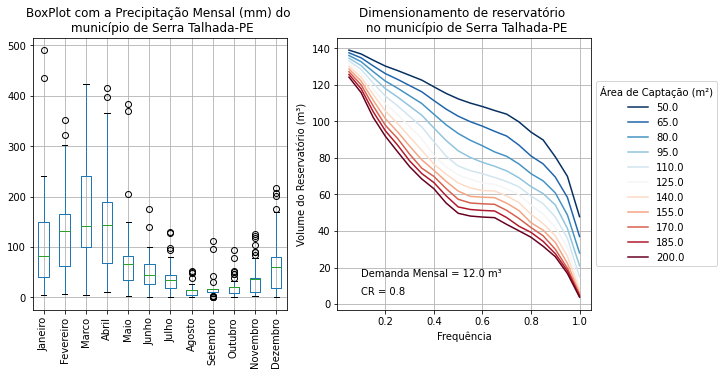

In [145]:
if __name__ == '__main__':
  name = '/content/data_rainfall_serratalhada_PE.csv'
  precipitacao = DadosPrec(name=name)
  chuva = precipitacao.quantile(.05) # mm
  demanda_mensal = .08*5*30 # m³
  area_de_captacao = 150 # m²
  cr = .8 # coeficient de runoff

  q = np.linspace(5, 100, 20)/100
  area_de_captacao = np.linspace(50, 200, 11)
  vol_dict = {}
  for a in area_de_captacao:
    vol = []
    for quantile in q:
      metodo = Rippl(precipitacao.quantile(quantile), demanda_mensal, a, cr)
      vol.append(metodo.vol_reserv())
    vol_dict[f'{a}'] = np.array(vol) 

  df_vol = pd.DataFrame(vol_dict)
  df_vol['Frequência'] = q
  fig, ax = plt.subplots(ncols = 2, figsize=(10, 5))
  ax = ax.ravel()

  df_vol.plot(ax=ax[1], grid=True, x = 'Frequência', colormap='RdBu_r')
  # ax[0].plot(q, vol)
  ax[1].set_ylabel(ylabel='Volume do Reservatório (m³)')
  ax[1].set_xlabel(xlabel='Frequência')
  ax[1].set_title('Dimensionamento de reservatório \n no município de Serra Talhada-PE')
  # ax[0].text(.1,20, f'Área de Captacao = {area_de_captacao} m²')
  ax[1].text(.1,15, f'Demanda Mensal = {demanda_mensal} m³')
  ax[1].text(.1,5, f'CR = {cr}')
  ax[1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Área de Captação (m²)')

  # vol_media = Rippl(precipitacao.quantile(.4), demanda_mensal, area_de_captacao, cr).vol_reserv()
  # ax[0].text(.4, vol_media , f' Media = {int(vol_media)} m³')

  # vol_med = Rippl(precipitacao.quantile(.5), demanda_mensal, area_de_captacao, cr).vol_reserv()
  # ax[0].text(.5, vol_med, f' Mediana = {int(vol_med)} m³')


  precipitacao.df.drop(['Ano', 'Codigo'], axis=1).boxplot(ax=ax[0], rot=90)
  ax[0].set_title('BoxPlot com a Precipitação Mensal (mm) do \n município de Serra Talhada-PE')

  fig.savefig('Dimensionamento de reservatório no município de Serra Talhada-PE'+'.pdf', dpi=300, bbox_inches='tight')